# Gibberish Classifier Model
- We use features created in a separate notebook to make a classifier that identifies if a piece of text is gibberish or not
- Ultimately, we find that a random forest works MUCH better than a few different baselines that we tried including randomly guessing a % of the reviews (based on the training set) are gibberish and guessing all reviews where the language can't be identified are gibberish.
- In fact, our model performs around 845% better on the F1 score.

In [1]:
!pip -q install transformers huggingface_hub langdetect pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 41.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 20.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.stats as stats
import re
import nltk
from nltk.corpus import words
from collections import Counter
import math
import unicodedata
import time
from tqdm import tqdm
import pickle
from langdetect import detect
import warnings
import pycountry
from scipy import stats
from collections import defaultdict
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
from sklearn.model_selection import train_test_split

# Load data created in gibberish_classifier_build_features
train_features = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/gibberish_train.pkl')
test_features = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/gibberish_test.pkl')

# Further split into validation and testing set
val_features, test_features = train_test_split(test_features, test_size=0.5, stratify=test_features['is_gibberish'], random_state=42)

In [4]:
print(f'{len(val_features)=}')
print(f'{len(test_features)=}')

len(val_features)=105234
len(test_features)=105235


## EDA of Gibberish Feature Set

In [5]:
# Sample for visualization (due to 1M+ rows)
num_features = ['entropy', 'word_count', 'n_chars', 'max_repeated', 'ngram_coherence',
            'punct_ratio','avg_word_length', 'cosine_to_centroid', 'anomaly_score']

cat_features = ['cannot_detect_language', 'has_chinese', 'has_cyrillic', 'has_abakada', 
                'has_hangul', 'has_latin']

train_features_num = train_features[num_features]
train_features_cat = train_features[cat_features]

In [6]:
train_features['language'].value_counts()

language
en         836933
es           1367
cy            669
da            296
sq            280
de            280
unknown       214
so            185
no            166
fr            144
sl            130
pt            127
af             84
pl             84
fi             83
hr             81
nl             78
vi             77
sv             77
hu             68
et             66
sw             57
it             50
sk             46
tl             45
cs             39
lt             38
lv             33
id             30
ca             17
ro             15
tr             15
Name: count, dtype: int64

#### Feature Selection
- Numeric features: Use anova f-stat to test how much is_gibberish varies from each
- Categoricals: Use chi2
- **Note:** We'll use a small sample that has equal amounts of gibberish and real reviews so we can get some more meaningful p-values for ranking things

In [7]:
# Create balanced sample for this process, experiment with smaller n values
sample_size = 500
real = train_features[train_features['is_gibberish'] == 0].sample(n=sample_size, random_state=42)
gibberish = train_features[train_features['is_gibberish'] == 1].sample(n=sample_size, random_state=42)  # All 3,700 (or less if train has fewer)
balanced_df = pd.concat([real, gibberish])

print(f"Balanced sample size: {len(balanced_df)}")
print(balanced_df['is_gibberish'].value_counts())

Balanced sample size: 1000
is_gibberish
0    500
1    500
Name: count, dtype: int64


In [8]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# For numeric features, use f score
X = balanced_df[num_features]
y = balanced_df['is_gibberish']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SelectKBest
selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X_scaled, y)

# Results
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_,
    'P-value': selector.pvalues_
}).sort_values(by='Score', ascending=False)
print("Balanced Sample Results:")
print(feature_scores.to_markdown())

Balanced Sample Results:
|    | Feature            |       Score |      P-value |
|---:|:-------------------|------------:|-------------:|
|  0 | entropy            | 2381.23     | 1.45955e-266 |
|  1 | word_count         | 1866.44     | 9.96787e-231 |
|  2 | n_chars            | 1801.11     | 1.00156e-225 |
|  8 | anomaly_score      | 1763.43     | 8.69945e-223 |
|  7 | cosine_to_centroid |  721.201    | 5.35043e-120 |
|  4 | ngram_coherence    |  580.445    | 1.85507e-101 |
|  6 | avg_word_length    |  156.791    | 1.62205e-33  |
|  3 | max_repeated       |    4.82678  | 0.0282502    |
|  5 | punct_ratio        |    0.883225 | 0.347547     |


Balanced Sample Results:
|    | Feature            |       Score |      P-value |
|---:|:-------------------|------------:|-------------:|
|  0 | entropy            | 2381.23     | 1.45955e-266 |
|  1 | word_count         | 1866.44     | 9.96787e-231 |
|  2 | n_chars            | 1801.11     | 1.00156e-225 |
|  8 | anomaly_score      | 1763.43     | 8.69945e-223 |
|  7 | cosine_to_centroid |  721.201    | 5.35043e-120 |
|  4 | ngram_coherence    |  580.445    | 1.85507e-101 |
|  6 | avg_word_length    |  156.791    | 1.62205e-33  |
|  3 | max_repeated       |    4.82678  | 0.0282502    |
|  5 | punct_ratio        |    0.883225 | 0.347547     |

Varying n to a bunch of relatively small values between 100 and 10k, we saw that the top 7 consistently had small -values. Considering anomaly score and cosine_to_centroid are linearly dependent, we'll keep anomaly score. Same for n_chars and word count. We'll probably just keep word count.

In [9]:
from sklearn.feature_selection import chi2

# Do the same with chi2 for the categorical features
X = balanced_df[cat_features]
y = balanced_df['is_gibberish']

# SelectKBest
selector = SelectKBest(score_func=chi2, k=5)
selector.fit(X, y)

# Results
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_,
    'P-value': selector.pvalues_
}).sort_values(by='Score', ascending=False)
print("Balanced Sample Results:")
print(feature_scores.to_markdown())

Balanced Sample Results:
|    | Feature                |   Score |       P-value |
|---:|:-----------------------|--------:|--------------:|
|  0 | cannot_detect_language |      40 |   2.53963e-10 |
|  5 | has_latin              |       0 |   1           |
|  1 | has_chinese            |     nan | nan           |
|  2 | has_cyrillic           |     nan | nan           |
|  3 | has_abakada            |     nan | nan           |
|  4 | has_hangul             |     nan | nan           |


Balanced Sample Results:
|    | Feature                |   Score |       P-value |
|---:|:-----------------------|--------:|--------------:|
|  0 | cannot_detect_language |      40 |   2.53963e-10 |
|  5 | has_latin              |       0 |   1           |
|  1 | has_chinese            |     nan | nan           |
|  2 | has_cyrillic           |     nan | nan           |
|  3 | has_abakada            |     nan | nan           |
|  4 | has_hangul             |     nan | nan           |

Notice the NaN values for our "is_language" flag. It was difficult to capture a case of any of these being non-zero because they make up such a small % of the total reviews. Similarly to our Coursera course review data set, the vast majority of the reivews use Latin or latin-adjacent alphabets. Ultimately, these flags could be interesting for a data set with more languages, but are unlikely to be useful here. However, the the language being unknown appears to be very significant.

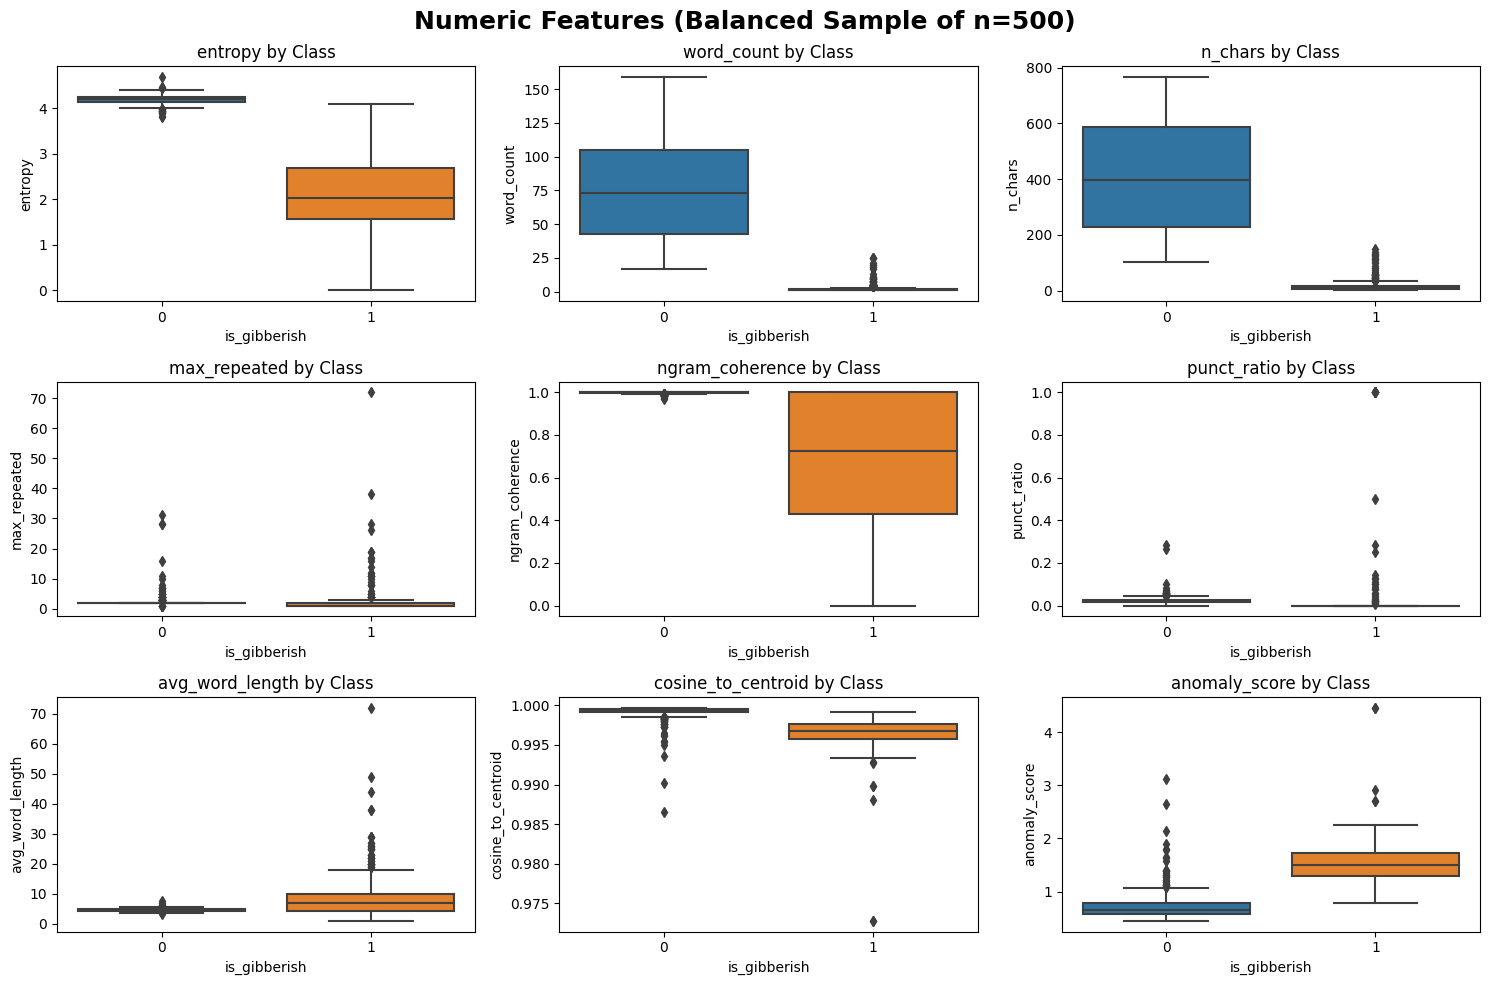

In [10]:
# Plot distributions of each of these numeric variables
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='is_gibberish', y=feature, data=balanced_df)
    plt.title(f'{feature} by Class')
plt.suptitle(f'Numeric Features (Balanced Sample of n={sample_size})', size=18, fontweight='bold')    
plt.tight_layout()
plt.savefig('gibberish_feature_dists.png')
plt.show()

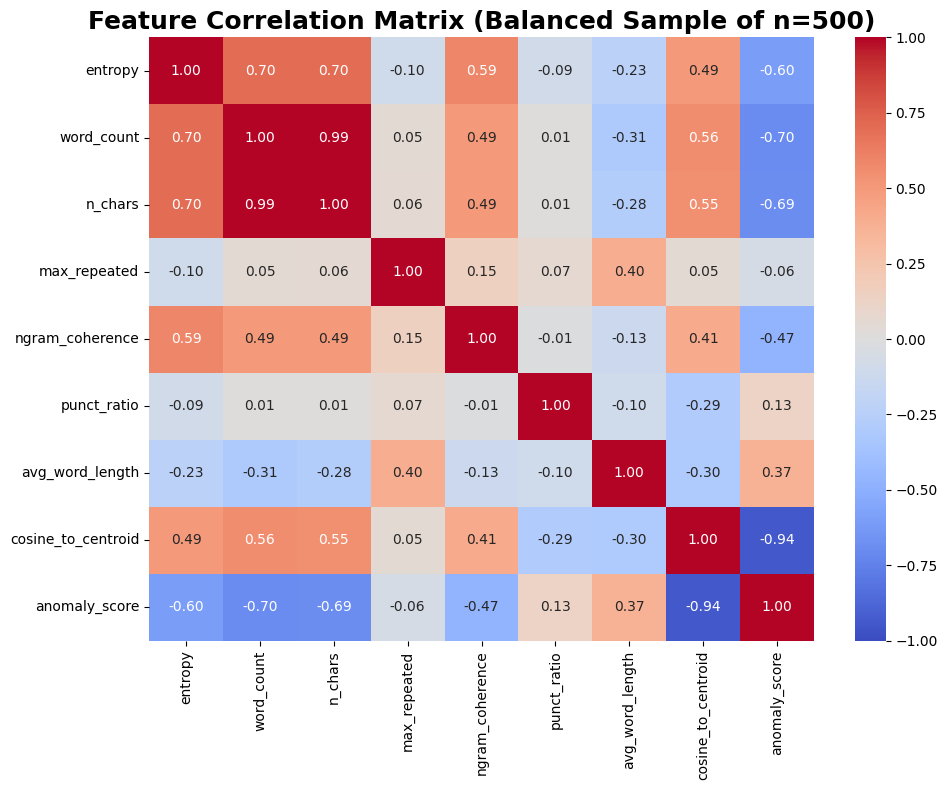

In [11]:
# Plot correlations between variables
corr = balanced_df[num_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title(f'Feature Correlation Matrix (Balanced Sample of n={sample_size})', size=18, fontweight='bold')
plt.tight_layout()
plt.savefig('gibberish_feature_corrs.png')
plt.show()

In [12]:
corr_threshold = 0.8
high_corr = set()
corr_matrix = corr.abs()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > corr_threshold:
            colname = corr_matrix.columns[i]
            high_corr.add(colname)

print("Highly correlated features to consider dropping:", high_corr)
#X_selected = X.drop(columns=high_corr)

Highly correlated features to consider dropping: {'n_chars', 'anomaly_score'}


Looks like we have some features to remove. We know that anomaly score and cosine to centroid are linearly dependant, so we'll keep anomaly score since it had a much higher ANOVA f score earlier. We'll toss n_chars in favor of word count. So our remaining features are:
1. Entropy
2. Word Count
3. Max Repeated
4. Ngram coherence
5. Punctuation Ratio
6. Average Word Length
7. Anomaly Score
8. Cannot Detect Language
Looking at the importances above, I expect we'll lose punctuation ratio and max repeated later.

In [13]:
balanced_df.columns

Index(['review', 'is_gibberish', 'entropy', 'language',
       'cannot_detect_language', 'alphabets', 'has_chinese', 'has_cyrillic',
       'has_abakada', 'has_hangul', 'has_latin', 'word_count', 'n_chars',
       'avg_word_length', 'max_repeated', 'punct_ratio', 'ngram_coherence',
       'cosine_to_centroid', 'anomaly_score'],
      dtype='object')

Feature Importance (All Features):
|    | Feature                |   Importance |
|---:|:-----------------------|-------------:|
|  9 | cannot_detect_language |   0.385838   |
|  0 | entropy                |   0.223072   |
|  2 | n_chars                |   0.171239   |
|  6 | avg_word_length        |   0.126694   |
|  4 | ngram_coherence        |   0.0380646  |
|  1 | word_count             |   0.021238   |
|  5 | punct_ratio            |   0.0149847  |
|  7 | cosine_to_centroid     |   0.00851155 |
|  8 | anomaly_score          |   0.00719214 |
|  3 | max_repeated           |   0.0031665  |


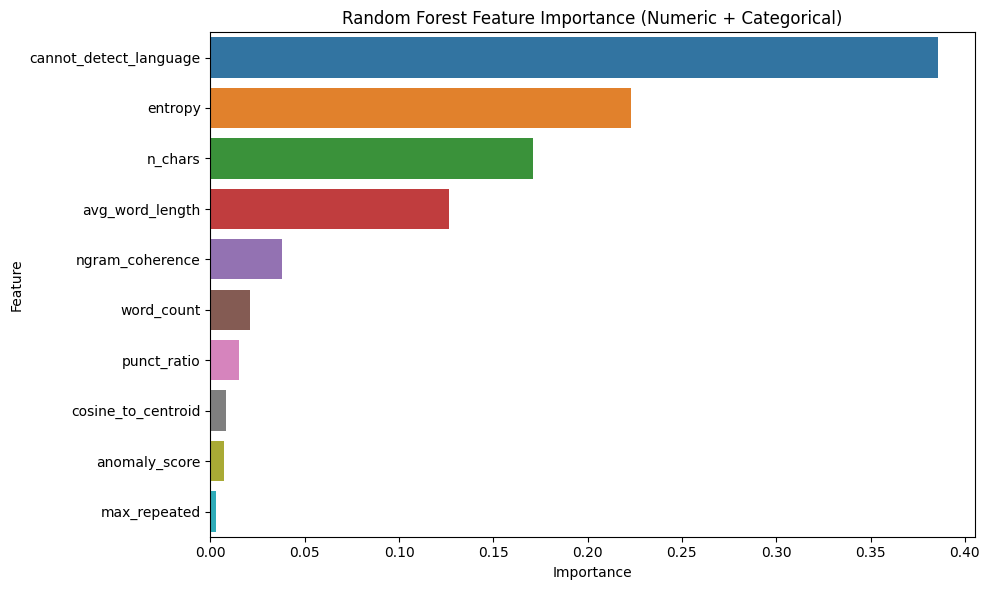

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Make dataset of numerical features and one
X = pd.concat([balanced_df[num_features], 
                                    balanced_df['cannot_detect_language']], axis=1)
y = balanced_df['cannot_detect_language']

# Train Random Forest (no scaling needed)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X, y)

# Feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importance (All Features):")
print(importances.to_markdown())

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Random Forest Feature Importance (Numeric + Categorical)')
plt.savefig('gibberish_rf_feature_importance.png')
plt.tight_layout()
plt.show()

Feature Importance (All Features):
|    | Feature                |   Importance |
|---:|:-----------------------|-------------:|
|  9 | cannot_detect_language |   0.385838   |
|  0 | entropy                |   0.223072   |
|  2 | n_chars                |   0.171239   |
|  6 | avg_word_length        |   0.126694   |
|  4 | ngram_coherence        |   0.0380646  |
|  1 | word_count             |   0.021238   |
|  5 | punct_ratio            |   0.0149847  |
|  7 | cosine_to_centroid     |   0.00851155 |
|  8 | anomaly_score          |   0.00719214 |
|  3 | max_repeated           |   0.0031665  |

Finally, let's cut features with a correlation threshold to confirm what we said above. We'll focus on the 8 most important features from the analysis above.

#### Data to Tune Hyperparameters
- We'll use a subset of 50k reviews using class_weight='balanced'.
- This will balance speed and realism of data. For tuning/deploying the final model, we'll use the full data set.
- Above, we used the balanced dataset so as to avoid huge majority class bias. But we don't want to over fit to finding gibberish, as it is quite rare in our real course reviews.

In [15]:
# Creating our tuning dataset making sure to stratify by % of actual gibberish
n_tuning = 50000
tuning_features = ['cannot_detect_language', 'entropy', 'word_count', 'avg_word_length',
                  'ngram_coherence', 'anomaly_score', 'punct_ratio', 'max_repeated']

# Subset for tuning (50k rows, stratified)
tune_set_train = train_features.groupby('is_gibberish', group_keys=False).apply(
    lambda x: x.sample(frac=n_tuning/len(train_features), random_state=42),
    include_groups=False
)
# Add 'is_gibberish' back after stratifying
tune_set_train = tune_set_train.join(train_features['is_gibberish'])

# Prepare training set for tuning
X_tune_train = tune_set_train[tuning_features]
y_tune_train = tune_set_train['is_gibberish']

# Prepare validation set for tuning
X_tune_val = val_features[tuning_features]
y_tune_val = val_features['is_gibberish']

print(f"Tuning subset size: {len(tune_set_train)}")
print(tune_set_train['is_gibberish'].value_counts())  # ~49,630 real, ~370 gibberish

Tuning subset size: 50000
is_gibberish
0    49821
1      179
Name: count, dtype: int64


In [16]:
from sklearn.preprocessing import StandardScaler
# We also need to separate our categorical/numericals
numeric_cols = ['entropy', 'word_count', 'avg_word_length','ngram_coherence', 
                    'anomaly_score', 'punct_ratio', 'max_repeated']
categorical_cols = ['cannot_detect_language']

# Scale numeric features only (for logistic regression and SVMs)
scaler = StandardScaler()
X_tune_train_numeric = scaler.fit_transform(X_tune_train[numeric_cols])
X_tune_val_numeric = scaler.transform(X_tune_val[numeric_cols]) # DOn't do fit transform her

# Combine with unscaled categorical
X_tune_train_scaled = np.hstack([X_tune_train_numeric, X_tune_train[categorical_cols]])
X_tune_val_scaled = np.hstack([X_tune_val_numeric, X_tune_val[categorical_cols]])

In [17]:
# Declare models and params to search through in giant dictionary
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Asked chatgpt to generate random parameters to try
models = {
    'Logistic Regression': {
        'model': LogisticRegression(class_weight='balanced', random_state=42),
        'params': {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']},
        'X_train': X_tune_train_scaled, # Use scaled features + unscaled categorical
        'X_val': X_tune_val_scaled
    },
    'Random Forest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]},
        'X_train': X_tune_train, # use all unscaled stuff
        'X_val': X_tune_val
    },
    'SVM': {
        'model': SVC(class_weight='balanced', random_state=42),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        'X_train': X_tune_train_scaled, # use scaled stuff
        'X_val': X_tune_val_scaled
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
        'X_train': X_tune_train, # Use unscaled
        'X_val': X_tune_val
    }
}

# Baseline 1: Random guess (99.6% real, 0.4% gibberish)
np.random.seed(42)
# Calculate the % of training set that is/isn't gibberish, then randomly guess that % is gibberish
gibberish_prob = np.sum(y_tune_train)/len(y_tune_train)
gibberish_proabs = [1-gibberish_prob, gibberish_prob]
y_baseline = np.random.choice([0, 1], size=len(y_tune_val), p=[1-gibberish_prob, gibberish_prob])

# Baseline 2: Guess gibberish whenever we can't detect language
y_baseline_lang = X_tune_val['cannot_detect_language'].astype(int)

# Baseline 3: Guess all non gibberish answers
y_baseline_all = np.ones_like(y_tune_val)

In [18]:
# Quick cross check of probabilities 
print(f'Probability of Real Entries in Training Set = {1-gibberish_prob:.2%}')
print(f'Probability of Gibberish in Training Set = {gibberish_prob:.2%}')

Probability of Real Entries in Training Set = 99.64%
Probability of Gibberish in Training Set = 0.36%


Next, we'll loop over our models dictionary to do the grid search over parameters. Note that if it is binary classification, GridSearchCV will default to using a Stratified KFold (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). We'll also get the precision, recall, f1, and some diagnostic curve info.

Training Models:   0%|          | 0/4 [00:00<?, ?it/s]


Tuning Logistic Regression...
Best params: {'C': 10, 'solver': 'lbfgs'}


Training Models:  25%|██▌       | 1/4 [00:04<00:14,  4.82s/it]

Logistic Regression Test Results (Subset-Tuned):
              precision    recall  f1-score   support

        real       1.00      1.00      1.00    104858
   gibberish       0.98      0.99      0.99       376

    accuracy                           1.00    105234
   macro avg       0.99      1.00      0.99    105234
weighted avg       1.00      1.00      1.00    105234


Tuning Random Forest...
Best params: {'max_depth': 10, 'n_estimators': 50}
Random Forest Test Results (Subset-Tuned):
              precision    recall  f1-score   support

        real       1.00      1.00      1.00    104858
   gibberish       1.00      0.99      0.99       376

    accuracy                           1.00    105234
   macro avg       1.00      0.99      1.00    105234
weighted avg       1.00      1.00      1.00    105234



Training Models:  50%|█████     | 2/4 [00:43<00:48, 24.48s/it]


Tuning SVM...
Best params: {'C': 10, 'kernel': 'linear'}


Training Models:  75%|███████▌  | 3/4 [00:56<00:19, 19.23s/it]

SVM Test Results (Subset-Tuned):
              precision    recall  f1-score   support

        real       1.00      1.00      1.00    104858
   gibberish       0.99      0.99      0.99       376

    accuracy                           1.00    105234
   macro avg       0.99      1.00      1.00    105234
weighted avg       1.00      1.00      1.00    105234


Tuning Gradient Boosting...
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Training Models: 100%|██████████| 4/4 [01:51<00:00, 27.85s/it]

Gradient Boosting Test Results (Subset-Tuned):
              precision    recall  f1-score   support

        real       1.00      1.00      1.00    104858
   gibberish       0.99      0.99      0.99       376

    accuracy                           1.00    105234
   macro avg       0.99      0.99      0.99    105234
weighted avg       1.00      1.00      1.00    105234



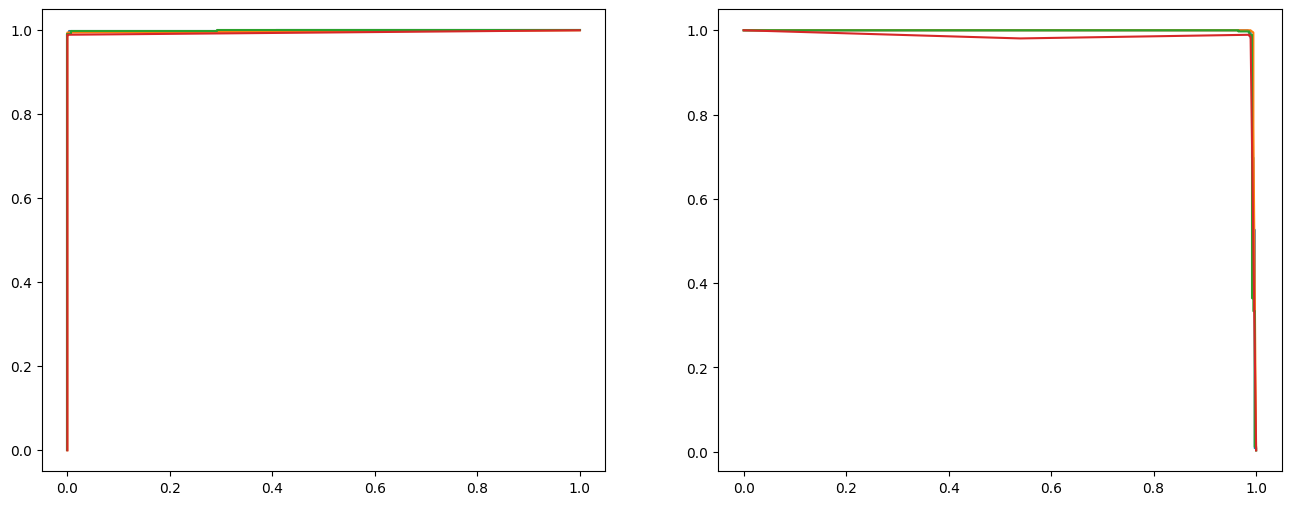

In [19]:
from sklearn.metrics import classification_report, auc, precision_recall_curve, roc_curve
from tqdm import tqdm

# Setup results dict
results = {}
# Begin figure to fill with ROC and PR curves
plt.figure(figsize=(16, 6))
# Loop over models and params above
for name, config in tqdm(models.items(), desc="Training Models"):
    print(f"\nTuning {name}...")
    clf = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    clf.fit(config['X_train'], y_tune_train)
    print(f"Best params: {clf.best_params_}")

    # Evaluate on validation set
    y_pred = clf.predict(config['X_val'])
    report = classification_report(y_tune_val, y_pred, target_names=['real', 'gibberish'], output_dict=True)
    print(f"{name} Test Results (Subset-Tuned):\n{classification_report(y_tune_val, y_pred, target_names=['real', 'gibberish'])}")

    # ROC Curve
    y_scores = clf.predict_proba(config['X_val'])[:, 1] if name != 'SVM' else clf.decision_function(config['X_val'])
    fpr, tpr, _ = roc_curve(y_tune_val, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    # Precision-Recall Curve
    #y_scores = clf.predict_proba(config['X_val'])[:, 1] if name != 'SVM' else clf.decision_function(config['X_test'])
    precision, recall, _ = precision_recall_curve(y_tune_val, y_scores)
    pr_auc = auc(recall, precision)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})')
    
    
    results[name] = {
        'best_params': clf.best_params_,
        'report': report,
        'precision_gibberish': report['gibberish']['precision'],
        'recall_gibberish': report['gibberish']['recall'],
        'f1_gibberish': report['gibberish']['f1-score'],
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }  

Baseline (Random Guess 99.6% Real, 0.4% Gibberish):
{'real': {'precision': 0.9964145059933058, 'recall': 0.9965000286101203, 'f1-score': 0.9964572654666825, 'support': 104858}, 'gibberish': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 376}, 'accuracy': 0.9929395442537583, 'macro avg': {'precision': 0.4982072529966529, 'recall': 0.49825001430506016, 'f1-score': 0.4982286327333412, 'support': 105234}, 'weighted avg': {'precision': 0.9928543272083743, 'recall': 0.9929395442537583, 'f1-score': 0.9928969339025921, 'support': 105234}}
Baseline (Gibberish if Language Not Detected):
              precision    recall  f1-score   support

        real       1.00      1.00      1.00    104858
   gibberish       1.00      0.09      0.16       376

    accuracy                           1.00    105234
   macro avg       1.00      0.54      0.58    105234
weighted avg       1.00      1.00      1.00    105234

Baseline (None are Gibberish):


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

        real       0.00      0.00      0.00    104858
   gibberish       0.00      1.00      0.01       376

    accuracy                           0.00    105234
   macro avg       0.00      0.50      0.00    105234
weighted avg       0.00      0.00      0.00    105234



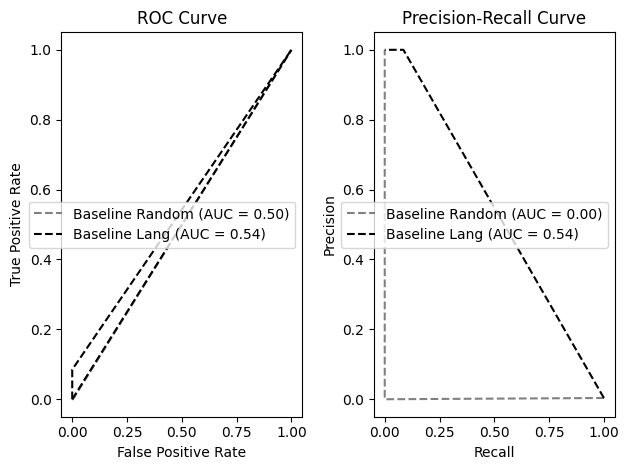


### Model Comparison (Test Set Results)
| Model                         | Best Parameters                                              |   Precision (Gibberish) |   Recall (Gibberish) |   F1-Score (Gibberish) |   ROC AUC |     PR AUC |
|:------------------------------|:-------------------------------------------------------------|------------------------:|---------------------:|-----------------------:|----------:|-----------:|
| Logistic Regression           | {'C': 10, 'solver': 'lbfgs'}                                 |              0.981579   |            0.992021  |             0.986772   |  0.998902 | 0.995229   |
| Random Forest                 | {'max_depth': 10, 'n_estimators': 50}                        |              0.997319   |            0.989362  |             0.993324   |  0.997338 | 0.996728   |
| SVM                           | {'C': 10, 'kernel': 'linear'}                                |              0.98939    |            0.992021  |             0.990704   |  0.9

In [20]:
# Baseline 1 - random guess based on training percentage
print("Baseline (Random Guess 99.6% Real, 0.4% Gibberish):")
baseline_report = classification_report(y_tune_val, y_baseline, target_names=['real', 'gibberish'], output_dict=True)
print(baseline_report)
# Compute ROC and PR AUC for baseline
fpr_base, tpr_base, _ = roc_curve(y_tune_val, y_baseline)
roc_auc_base = auc(fpr_base, tpr_base)
precision_base, recall_base, _ = precision_recall_curve(y_tune_val, y_baseline)
pr_auc_base = auc(recall_base, precision_base)

# Baseline 2: Label as Gibberish if language not detected
baseline_lang_report = classification_report(y_tune_val, y_baseline_lang, target_names=['real', 'gibberish'], output_dict=True)
print("Baseline (Gibberish if Language Not Detected):")
print(classification_report(y_tune_val, y_baseline_lang, target_names=['real', 'gibberish']))
fpr_base_lang, tpr_base_lang, _ = roc_curve(y_tune_val, y_baseline_lang)
roc_auc_base_lang = auc(fpr_base_lang, tpr_base_lang)
precision_base_lang, recall_base_lang, _ = precision_recall_curve(y_tune_val, y_baseline_lang)
pr_auc_base_lang = auc(recall_base_lang, precision_base_lang)

#Baseline 3: Label all as not gibberish
baseline_all_report = classification_report(y_tune_val, y_baseline_all, target_names=['real', 'gibberish'], output_dict=True)
print("Baseline (None are Gibberish):")
print(classification_report(y_tune_val, y_baseline_all, target_names=['real', 'gibberish']))
fpr_base_all, tpr_base_all, _ = roc_curve(y_tune_val, y_baseline_all)
roc_auc_base_all = auc(fpr_base_all, tpr_base_all)
precision_base_all, recall_base_all, _ = precision_recall_curve(y_tune_val, y_baseline_all)
pr_auc_base_all = auc(recall_base_all, precision_base_all)


# Plot ROC and PR curves
plt.subplot(1, 2, 1)
plt.plot(fpr_base, tpr_base, label=f'Baseline Random (AUC = {roc_auc_base:.2f})', linestyle='--', color='gray')
plt.plot(fpr_base_lang, tpr_base_lang, label=f'Baseline Lang (AUC = {roc_auc_base_lang:.2f})', linestyle='--', color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

# Plot precision recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_base, precision_base, label=f'Baseline Random (AUC = {pr_auc_base:.2f})', linestyle='--', color='gray')
plt.plot(recall_base_lang, precision_base_lang, label=f'Baseline Lang (AUC = {pr_auc_base_lang:.2f})', linestyle='--', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('gibberish_detector_roc_auc.png')
plt.show()

# Markdown table of results (including both baselines)
results_df = pd.DataFrame({
    'Model': list(results.keys()) + ['Baseline (Random Guess)', 'Baseline (Lang Not Detected)', 'Baseline (None are gibberish)'],
    'Best Parameters': [str(results[name]['best_params']) for name in results] + ['Gibberish Prob = 0.00358', 'cannot_detect_language = 1', "None Gibberish"],
    'Precision (Gibberish)': [results[name]['precision_gibberish'] for name in results] + [baseline_report['gibberish']['precision'], baseline_lang_report['gibberish']['precision'], baseline_all_report['gibberish']['precision']],
    'Recall (Gibberish)': [results[name]['recall_gibberish'] for name in results] + [baseline_report['gibberish']['recall'], baseline_lang_report['gibberish']['recall'], baseline_all_report['gibberish']['recall']],
    'F1-Score (Gibberish)': [results[name]['f1_gibberish'] for name in results] + [baseline_report['gibberish']['f1-score'], baseline_lang_report['gibberish']['f1-score'], baseline_all_report['gibberish']['f1-score']],
    'ROC AUC': [results[name]['roc_auc'] for name in results] + [roc_auc_base, roc_auc_base_lang, roc_auc_base_all],
    'PR AUC': [results[name]['pr_auc'] for name in results] + [pr_auc_base, pr_auc_base_lang, pr_auc_base_all]
})

print("\n### Model Comparison (Test Set Results)")
print(results_df.to_markdown(index=False))

### Model Comparison (Test Set Results)
| Model                        | Best Parameters                                              |   Precision (Gibberish) |   Recall (Gibberish) |   F1-Score (Gibberish) |   ROC AUC |     PR AUC |
|:-----------------------------|:-------------------------------------------------------------|------------------------:|---------------------:|-----------------------:|----------:|-----------:|
| Logistic Regression          | {'C': 10, 'solver': 'lbfgs'}                                 |              0.981579   |           0.992021   |             0.986772   |  0.998902 | 0.995229   |
| Random Forest                | {'max_depth': 10, 'n_estimators': 50}                        |              0.997319   |           0.989362   |             0.993324   |  0.997338 | 0.996728   |
| SVM                          | {'C': 10, 'kernel': 'linear'}                                |              0.98939    |           0.992021   |             0.990704   |  0.999187 | 0.993797   |
| Gradient Boosting            | {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} |              0.989333   |           0.986702   |             0.988016   |  0.994653 | 0.982619   |
| Baseline (Random Guess)      | Gibberish Prob = 0.00358                                     |              0.00544959 |           0.00530504 |             0.00537634 |  0.500912 | 0.00715904 |
| Baseline (Lang Not Detected) | cannot_detect_language = 1                                   |              0.954545   |           0.0557029  |             0.105263   |  0.527847 | 0.506816   |


#### Train Model for Deployment on full Training Set
- Train on all training data
- Test on final test holdout set
- Deploy model by exporting to pkl for use on coursera reviews
- Note: We end up scaling the numeric features for consistency, but since we know RF is the best performing model, we don't actually need to scale.

In [21]:
# Quantify improvement over new baseline
best_model_name = max(results, key=lambda x: results[x]['pr_auc'])
best_pr_auc = results[best_model_name]['pr_auc']
improvement_lang = best_pr_auc - pr_auc_base_lang
relative_improvement_lang = best_pr_auc / pr_auc_base_lang if pr_auc_base_lang > 0 else float('inf')
print(f"\nBest Model (Highest PR AUC): {best_model_name}")
print(f"Improvement over Lang Not Detected Baseline (PR AUC): {improvement_lang:.4f} absolute, {relative_improvement_lang:.1f}x relative")


Best Model (Highest PR AUC): Random Forest
Improvement over Lang Not Detected Baseline (PR AUC): 0.4525 absolute, 1.8x relative


In [22]:
# Prepare the full training set
X_train_full = train_features[tuning_features]
y_train_full = train_features['is_gibberish']

# Prepare final testing set
X_test = test_features[tuning_features]
y_test = test_features['is_gibberish']

# Final training on full dataset (note, we don't actually need this since RF is best model)
print(f"\nTraining {best_model_name} on full dataset with best params: {results[best_model_name]['best_params']}")
X_train_full_numeric = scaler.transform(X_train_full[numeric_cols])
X_train_full_scaled = np.hstack([X_train_full_numeric, X_train_full[categorical_cols]])

X_test_numeric = scaler.transform(X_test[numeric_cols])
X_test_scaled = np.hstack([X_test_numeric, X_test[categorical_cols]])


Training Random Forest on full dataset with best params: {'max_depth': 10, 'n_estimators': 50}


In [23]:
print(f'Length of Full Training Dataset = {len(X_train_full_scaled)}')
print(f'Length of Testing Dataset = {len(X_test_scaled)}')

Length of Full Training Dataset = 841874
Length of Testing Dataset = 105235


In [24]:
# Define and train best model
if best_model_name == 'Logistic Regression':
    final_model = LogisticRegression(class_weight='balanced', random_state=42, **results[best_model_name]['best_params'])
    X_train_final = X_train_full_scaled
    X_test_final = X_test_scaled
elif best_model_name == 'Random Forest':
    final_model = RandomForestClassifier(class_weight='balanced', random_state=42, **results[best_model_name]['best_params'])
    X_train_final = X_train_full
    X_test_final = X_test
elif best_model_name == 'SVM':
    final_model = SVC(class_weight='balanced', random_state=42, probability=True, **results[best_model_name]['best_params'])
    X_train_final = X_train_full_scaled
    X_test_final = X_test_scaled
elif best_model_name == 'Gradient Boosting':
    final_model = GradientBoostingClassifier(random_state=42, **results[best_model_name]['best_params'])
    X_train_final = X_train_full
    X_test_final = X_test

# Train with progress bar
with tqdm(total=1, desc=f"Fitting {best_model_name} on Full Data") as pbar:
    final_model.fit(X_train_final, y_train_full)
    pbar.update(1)

# Final evaluation
y_pred_final = final_model.predict(X_test)
print(f"\nFinal {best_model_name} Full Data Results:")
print(classification_report(y_test, y_pred_final, target_names=['real', 'gibberish']))

Fitting Random Forest on Full Data: 100%|██████████| 1/1 [00:32<00:00, 32.04s/it]



Final Random Forest Full Data Results:
              precision    recall  f1-score   support

        real       1.00      1.00      1.00    104858
   gibberish       1.00      0.99      1.00       377

    accuracy                           1.00    105235
   macro avg       1.00      1.00      1.00    105235
weighted avg       1.00      1.00      1.00    105235



In [25]:
# Save model for deployment
import pickle

model_filename = f'gibberish_{best_model_name.lower().replace(" ", "_")}_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(final_model, file)
print(f"Saved model to {model_filename}")

Saved model to gibberish_random_forest_model.pkl
